# Project 1 Modeling: Regression

Build regression models and evaluate and analyze the best model for insights.

- Use **team pitching stats** and **team batting stats** to build

In [1]:
import pandas as pd

import sys
import os
home_directory_path = os.path.expanduser('~')
sys.path.append(home_directory_path +'/utils')

from prepare_utils import split_data

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler

import model as m

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import numpy as np

Acquire data

In [2]:
tm_batting = pd.read_csv('data/team_batting.csv')
tm_pitching = pd.read_csv('data/team_pitching.csv')

Split data

In [3]:
tm_batting_train,\
    tm_batting_validate,\
        tm_batting_test = split_data(tm_batting, validate_size=.15, test_size=.15, random_state=123)

In [4]:
tm_pitching_train = tm_pitching.loc[tm_batting_train.index]
tm_pitching_validate = tm_pitching.loc[tm_batting_validate.index]
tm_pitching_test = tm_pitching.loc[tm_batting_test.index]

In [5]:
train = pd.merge(left = tm_batting_train, right = tm_pitching_train, on=['year','Tm','W'], 
         suffixes= ("_bat", "_pit"))
validate = pd.merge(left = tm_batting_validate, right = tm_pitching_validate, on=['year','Tm','W'], 
         suffixes= ("_bat", "_pit"))
test = pd.merge(left = tm_batting_test, right = tm_pitching_test, on=['year','Tm','W'], 
         suffixes= ("_bat", "_pit"))

Features to model on:
- `['OPS+', 'HR_bat', 'BatAge', 'OPS_pit', 'BB_pit', 'PAge']`
- `['OPS+', 'HR_bat', 'BatAge', 'WHIP', 'HR_pit', 'PAge']`

In [6]:
X_train = train[['OPS+', 'HR_bat', 'BatAge', 'OPS_pit', 'BB_pit', 'PAge']]
X_validate = validate[['OPS+', 'HR_bat', 'BatAge', 'OPS_pit', 'BB_pit', 'PAge']]
X_test = test[['OPS+', 'HR_bat', 'BatAge', 'OPS_pit', 'BB_pit', 'PAge']]

y_train = train[['W']]
y_validate = validate[['W']]
y_test = test[['W']]

**Preprocess Data**

- No categoricals to encode
- Scale Features

In [7]:
def split_mlb_data(tm_batting=pd.read_csv('data/team_batting.csv'), 
                   tm_pitching=pd.read_csv('data/team_pitching.csv')):
    
    # split batting data
    tm_batting_train,\
        tm_batting_validate,\
            tm_batting_test = split_data(tm_batting, validate_size=.15, test_size=.15, random_state=123)
    
    # split pitching data
    tm_pitching_train = tm_pitching.loc[tm_batting_train.index]
    tm_pitching_validate = tm_pitching.loc[tm_batting_validate.index]
    tm_pitching_test = tm_pitching.loc[tm_batting_test.index]
    
    # join pitching and batting stats
    train = pd.merge(left = tm_batting_train, right = tm_pitching_train, on=['year','Tm','W'], 
         suffixes= ("_bat", "_pit"))
    validate = pd.merge(left = tm_batting_validate, right = tm_pitching_validate, on=['year','Tm','W'], 
             suffixes= ("_bat", "_pit"))
    test = pd.merge(left = tm_batting_test, right = tm_pitching_test, on=['year','Tm','W'], 
             suffixes= ("_bat", "_pit"))
    
    return train, validate, test


def scale_mlb_data(train=split_mlb_data()[0],
                   validate=split_mlb_data()[1],
                   test=split_mlb_data()[2],
                   features=['OPS+', 'HR_bat', 'BatAge', 'OPS_pit', 'BB_pit', 'PAge'],
                   target=['W']):
    
    # separate features to scale
    X_train = train[features]
    X_validate = validate[features]
    X_test = test[features]

    y_train = train[target]
    y_validate = validate[target]
    y_test = test[target]
    
    # scale data
    scaler = MinMaxScaler()

    train_sc = pd.concat([pd.DataFrame(data=scaler.fit_transform(X_train),
                                       columns=X_train.columns), y_train],
                                       axis=1)
    validate_sc = pd.concat([pd.DataFrame(data=scaler.transform(X_validate),
                                          columns=X_validate.columns), y_validate],
                                      axis=1)
    test_sc = pd.concat([pd.DataFrame(data=scaler.transform(X_test), 
                                      columns=X_test.columns), y_train],
                                      axis=1)
    return train_sc, validate_sc, test_sc

In [8]:
scaler = MinMaxScaler()

train_sc = pd.concat([pd.DataFrame(data=scaler.fit_transform(X_train),
                                   columns=X_train.columns), y_train], axis=1)
validate_sc = pd.concat([pd.DataFrame(data=scaler.transform(X_validate),
                                      columns=X_validate.columns), y_validate], axis=1)
test_sc = pd.concat([pd.DataFrame(data=scaler.transform(X_test), 
                                  columns=X_test.columns), y_train], axis=1)

**Build Baseline Model**

In [9]:
def run_baseline_model(train, test, features, target):
    
    # split X and y
    X_train = train[features]
    X_test = test[features]

    y_train = train[target]
    y_test = test[target]
    
    # run model
    dummy = DummyRegressor().fit(X_train, y_train)    
    
    # RMSE
    train_rmse = mean_squared_error(y_train, dummy.predict(X_train), squared=False)
    test_rmse = mean_squared_error(y_test, dummy.predict(X_test), squared=False)
    # R2
    train_r2 = r2_score(y_train, dummy.predict(X_train))
    test_r2 = r2_score(y_test, dummy.predict(X_test))
    
    print(f'Train:\tRMSE = {round(train_rmse, 2)}\tR2 = {train_r2}')
    print(f'Test:\tRMSE = {round(test_rmse, 2)}\tR2 = {round(test_r2, 2)}')
    
    return train_rmse, train_r2, test_rmse, test_r2

In [10]:
features = ['OPS+', 'HR_bat', 'BatAge', 'OPS_pit', 'BB_pit', 'PAge']
target = ['W']

run_baseline_model(train_sc, validate_sc, features, target)

Train:	RMSE = 11.57	R2 = 0.0
Test:	RMSE = 12.76	R2 = -0.0


(11.56561341695243, 0.0, 12.76452386819026, -0.00025074814483039276)

Baseline model predictions are off by 12.76 Wins on average

**Model**

In [11]:
def run_linear_model(train, test, features, target, scaler):
    
    # split X and y
    X_train = train[features]
    X_test = test[features]

    y_train = train[target]
    y_test = test[target]
    
    # run model
    lm = LinearRegression().fit(X_train, y_train)    
    
    # RMSE
    train_rmse = mean_squared_error(y_train, lm.predict(X_train), squared=False)
    test_rmse = mean_squared_error(y_test, lm.predict(X_test), squared=False)
    # R2
    train_r2 = r2_score(y_train, lm.predict(X_train))
    test_r2 = r2_score(y_test, lm.predict(X_test))
    
    print(f'Train:\tRMSE = {train_rmse}\tR2 = {train_r2}')
    print(f'Test:\tRMSE = {test_rmse}\tR2 = {test_r2}')
    
    df_scaled = pd.DataFrame(np.append(lm.coef_, lm.intercept_),
                             index=features + ['Intercept'],
                             columns=['Scaled Coeffs'])
    
    df_unscaled = pd.DataFrame(np.append(lm.coef_ * scaler.scale_, lm.intercept_),
                               index=features + ['Intercept'],
                               columns=['Unscaled Coeffs'])
    # Concatenate the two DataFrames horizontally
    result_df = pd.concat([df_scaled, df_unscaled], axis=1)

    # Display the combined DataFrame
    display(result_df)
    
    return train_rmse, train_r2, test_rmse, test_r2

In [12]:
def run_GBRegression_model(train, test, features, target):
    # split X and y
    X_train = train[features]
    X_test = test[features]

    y_train = train[target]
    y_test = test[target]
    
    # run model
#     gbr = GradientBoostingRegressor(random_state=123).fit(X_train, y_train)
#     gbr = GradientBoostingRegressor(learning_rate=0.03801806702724453, max_depth=6,
#                                       n_estimators=611, random_state=123,
#                                       subsample=0.12157377354410015).fit(X_train, y_train)
    gbr = GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                                    random_state=123, subsample=0.5)\
                                    .fit(X_train, y_train)
    
    # RMSE
    train_rmse = mean_squared_error(y_train, gbr.predict(X_train), squared=False)
    test_rmse = mean_squared_error(y_test, gbr.predict(X_test), squared=False)
    # R2
    train_r2 = r2_score(y_train, gbr.predict(X_train))
    test_r2 = r2_score(y_test, gbr.predict(X_test))
    
    print(f'Train:\tRMSE = {train_rmse}\tR2 = {train_r2}')
    print(f'Test:\tRMSE = {test_rmse}\tR2 = {test_r2}')
    
#     # Plot feature importance
#     feature_importance = gbr.feature_importances_
#     sorted_idx = np.argsort(feature_importance)
#     pos = np.arange(sorted_idx.shape[0]) + 0.5
#     fig = plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.barh(pos, feature_importance[sorted_idx], align="center")
#     plt.yticks(pos, np.array(features)[sorted_idx])
#     plt.title("Feature Importance (MDI)")

#     result = permutation_importance(
#         gbr, X_test, y_test, n_repeats=10, random_state=123, n_jobs=2
#     )
#     sorted_idx = result.importances_mean.argsort()
#     plt.subplot(1, 2, 2)
#     plt.boxplot(
#         result.importances[sorted_idx].T,
#         vert=False,
#         labels=np.array(features)[sorted_idx],
#     )
#     plt.title("Permutation Importance (test set)")
#     fig.tight_layout()
#     plt.show()
    
    return train_rmse, train_r2, test_rmse, test_r2

**Modeling 1**

In [13]:
features = ['OPS+', 'HR_bat', 'BatAge', 'OPS_pit', 'BB_pit', 'PAge']
target = ['W']

X_train = train[features]
X_validate = validate[features]
X_test = test[features]

scaler = MinMaxScaler()

train_sc = pd.concat([pd.DataFrame(data=scaler.fit_transform(X_train),
                                   columns=X_train.columns), y_train], axis=1)
validate_sc = pd.concat([pd.DataFrame(data=scaler.transform(X_validate),
                                      columns=X_validate.columns), y_validate], axis=1)
test_sc = pd.concat([pd.DataFrame(data=scaler.transform(X_test), 
                                  columns=X_test.columns), y_train], axis=1)

Linear Model 1:

In [14]:
run_linear_model(train_sc, validate_sc, features, target, scaler)

Train:	RMSE = 5.976115794599631	R2 = 0.7330065150117421
Test:	RMSE = 6.377480523490603	R2 = 0.7503118524362912


,Scaled Coeffs,Unscaled Coeffs
OPS+,27.948589,0.558972
HR_bat,11.558619,0.053512
BatAge,9.390650,1.159340
OPS_pit,-33.414173,-147.850322
BB_pit,-4.845732,-0.014086
PAge,2.762821,0.349724
Intercept,78.668139,78.668139


(5.976115794599631, 0.7330065150117421, 6.377480523490603, 0.7503118524362912)

Linear Regression Model predictions are off by 6.4 on average

The model's unscaled coefficients tell us how many wins are added if the feature is increased from the min to the max. So, we can see, with all of the features being on the same scale (0-1), which ones are most important. 

The model's scaled coefficients tell us how many wins are added per unit of the feature.

|     |   Wins Added per Unit |    Unit   |
|:-----|:-----------------------|:-----------|
|OPS+ |           5.5         |      10 points    |
|HRs hit |        .5         |      10 HRs |
|Batters age |      1.15      |      1 yr |
|OPS allowed  |   1.47        |  .010 percentage point  |
|Walks allowed|    .1        |        10 BBs |
|Pitchers age |    .35        |       1 yr      |
|Intercept    |   78.7        |                 |

Gradient Boosting Regressor 1:

In [15]:
run_GBRegression_model(train_sc, validate_sc, features, target)

/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train:	RMSE = 3.5538996582732474	R2 = 0.9055780468610032
Test:	RMSE = 6.523679236323366	R2 = 0.7387328286069503


(3.5538996582732474, 0.9055780468610032, 6.523679236323366, 0.7387328286069503)

**Second Linear Regression Model**

In [16]:
X_train = train[['OPS+', 'HR_bat', 'BatAge', 'WHIP', 'HR_pit', 'PAge']]
X_validate = validate[['OPS+', 'HR_bat', 'BatAge', 'WHIP', 'HR_pit', 'PAge']]
X_test = test[['OPS+', 'HR_bat', 'BatAge', 'WHIP', 'HR_pit', 'PAge']]

scaler = MinMaxScaler()

train_sc = pd.concat([pd.DataFrame(data=scaler.fit_transform(X_train),
                                   columns=X_train.columns), y_train], axis=1)
validate_sc = pd.concat([pd.DataFrame(data=scaler.transform(X_validate),
                                      columns=X_validate.columns), y_validate], axis=1)
test_sc = pd.concat([pd.DataFrame(data=scaler.transform(X_test), 
                                  columns=X_test.columns), y_train], axis=1)

Linear Model 2:

In [17]:
features = ['OPS+', 'HR_bat', 'BatAge', 'WHIP', 'HR_pit', 'PAge']
target = ['W']

run_linear_model(train_sc, validate_sc, features, target, scaler)

Train:	RMSE = 5.739236346216788	R2 = 0.7537530411039646
Test:	RMSE = 6.178030767141026	R2 = 0.765685168584508


,Scaled Coeffs,Unscaled Coeffs
OPS+,26.894108,0.537882
HR_bat,16.306621,0.075494
BatAge,8.286779,1.023059
WHIP,-25.763570,-53.011461
HR_pit,-23.645773,-0.113138
PAge,1.903728,0.240978
Intercept,79.477724,79.477724


(5.739236346216788, 0.7537530411039646, 6.178030767141026, 0.765685168584508)

Linear Regression Model predictions are off by 6.2 on average

**Gradient Boosting regression 2**

In [18]:
run_GBRegression_model(train_sc, validate_sc, features, target)

/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train:	RMSE = 3.5293117809905263	R2 = 0.9068800556002033
Test:	RMSE = 6.410295445496042	R2 = 0.7477357327232406


(3.5293117809905263, 0.9068800556002033, 6.410295445496042, 0.7477357327232406)

---
`model.py`

In [19]:
from sklearn.metrics import mean_squared_error, r2_score


def run_baseline_model(train, test, features, target):
    
    # split X and y
    X_train = train[features]
    X_test = test[features]

    y_train = train[target]
    y_test = test[target]
    
    # run model
    dummy = DummyRegressor().fit(X_train, y_train)    
    
    # RMSE
    train_rmse = mean_squared_error(y_train, dummy.predict(X_train), squared=False)
    test_rmse = mean_squared_error(y_test, dummy.predict(X_test), squared=False)
    # R2
    train_r2 = r2_score(y_train, dummy.predict(X_train))
    test_r2 = r2_score(y_test, dummy.predict(X_test))
    
    print(f'Train:\tRMSE = {train_rmse}\tR2 = {train_r2}')
    print(f'Test:\tRMSE = {test_rmse}\tR2 = {test_r2}')
    
    return train_rmse, train_r2, test_rmse, test_r2



def run_linear_model(train, test, features, target):
    
    # split X and y
    X_train = train[features]
    X_test = test[features]

    y_train = train[target]
    y_test = test[target]
    
    # run model
    lm = LinearRegression().fit(X_train, y_train)    
    
    # RMSE
    train_rmse = mean_squared_error(y_train, lm.predict(X_train), squared=False)
    test_rmse = mean_squared_error(y_test, lm.predict(X_test), squared=False)
    # R2
    train_r2 = r2_score(y_train, lm.predict(X_train))
    test_r2 = r2_score(y_test, lm.predict(X_test))
    
    print(f'Train:\tRMSE = {train_rmse}\tR2 = {train_r2}')
    print(f'Test:\tRMSE = {test_rmse}\tR2 = {test_r2}')
    
    return train_rmse, train_r2, test_rmse, test_r2

Testing CV methods

In [20]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore")

In [21]:
model = GradientBoostingRegressor(random_state=123)
parameters = {'learning_rate': uniform(),
              'subsample'    : uniform(),
              'n_estimators' : randint(100, 1000),
              'max_depth'    : randint(4, 10)}
randm = RandomizedSearchCV(estimator=model,
                           param_distributions=parameters,
                           cv=2, n_iter=10, n_jobs=-1)
randm.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

RandomizedSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=123),
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fad9bef9d50>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fad9bef9d20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fad9befa080>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fad9befa650>})

In [22]:
print('Best estimator across all search params:\n',
      randm.best_estimator_)
print('\nBest score across all search params:\n',
      randm.best_score_)
print('\nBest parameters across all search params:\n',
      randm.best_params_)

Best estimator across all search params:
 GradientBoostingRegressor(learning_rate=0.014220766615776648, max_depth=4,
                          n_estimators=260, random_state=123,
                          subsample=0.8522415310796466)

Best score across all search params:
 0.6703728896176391

Best parameters across all search params:
 {'learning_rate': 0.014220766615776648, 'max_depth': 4, 'n_estimators': 260, 'subsample': 0.8522415310796466}


In [23]:
model = GradientBoostingRegressor(random_state=123)
parameters = {'learning_rate': [.01, .02, .03],
              'subsample'    : [.9, .5, .2],
              'n_estimators' : [100, 500, 1000],
              'max_depth'    : [4, 6, 8]}
grid = GridSearchCV(estimator=model,
                    param_grid=parameters,
                    cv=2, n_jobs=-1)
grid.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.9, 0.5, 0.2]})

In [24]:
print('Best estimator across all search params:\n',
      grid.best_estimator_)
print('\nBest score across all search params:\n',
      grid.best_score_)
print('\nBest parameters across all search params:\n',
      grid.best_params_)

Best estimator across all search params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                          random_state=123, subsample=0.5)

Best score across all search params:
 0.6686598645679744

Best parameters across all search params:
 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.5}


Testing Neural Networks

In [25]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-07-26 21:58:13.426412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
tf.random.set_seed(123)
model = keras.Sequential([
            layers.Dense(64, activation=tf.nn.relu, input_shape=[len(features)]),
            layers.Dense(64, activation=tf.nn.relu),
            layers.Dense(1)
        ])

model.compile(loss='mse',
              optimizer=keras.optimizers.RMSprop(.001),
              metrics=['mae', 'mse'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4673 (18.25 KB)
Trainable params: 4673 (18.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
X_train

,OPS+,HR_bat,BatAge,WHIP,HR_pit,PAge
0,99,168,28.3,1.343,185,28.6
1,96,186,28.3,1.353,179,27.6
2,102,155,27.7,1.405,140,27.4
3,88,144,31.9,1.305,171,31.8
4,93,138,27.1,1.470,173,27.3
...,...,...,...,...,...,...
351,97,159,27.0,1.401,160,26.3
352,102,209,29.9,1.420,181,28.4
353,91,159,27.7,1.436,136,28.3
354,95,167,31.1,1.365,197,30.9


In [30]:
model.predict(X_train)

12/12 [==============================] - 0s 1ms/step


array([[36.284798],
       [38.25125 ],
       [28.040495],
       [32.4576  ],
       [31.546173],
       [26.727316],
       [27.673521],
       [37.9181  ],
       [32.157967],
       [38.46586 ],
       [33.911377],
       [41.590424],
       [28.030476],
       [26.20325 ],
       [45.923744],
       [32.88989 ],
       [50.178707],
       [36.464905],
       [37.060753],
       [46.464806],
       [30.801945],
       [56.670185],
       [29.26345 ],
       [37.245705],
       [31.95721 ],
       [28.36134 ],
       [28.817783],
       [36.0226  ],
       [36.465645],
       [32.99688 ],
       [43.784378],
       [21.265835],
       [32.70404 ],
       [26.71856 ],
       [28.219452],
       [23.306755],
       [39.20444 ],
       [33.92427 ],
       [34.113464],
       [49.109215],
       [33.922676],
       [29.792664],
       [34.65182 ],
       [36.32504 ],
       [30.322329],
       [32.85876 ],
       [49.083866],
       [32.710648],
       [52.550056],
       [20.810207],


In [31]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 250 == 0: print('')
        print('.', end='')
EPOCHS = 1000

history = model.fit(
                    X_train,
                    y_train,
                    epochs=EPOCHS,
                    validation_split=.2,
                    verbose=0,
                    callbacks=[PrintDot()]
                    )


..........................................................................................................................................................................................................................................................
..........................................................................................................................................................................................................................................................
..........................................................................................................................................................................................................................................................
......................................................................................................................................................................................................................................................

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist['rmse_difference'] = (hist['val_mse'] ** .5) - (hist['mse'] ** .5)
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch,rmse_difference
0,549.608948,18.491474,549.608948,348.674194,14.612859,348.674194,0,-4.770920
1,216.354309,11.942027,216.354309,265.921844,13.126770,265.921844,1,1.598123
2,182.010773,10.937763,182.010773,242.734558,12.274571,242.734558,2,2.088804
3,158.271011,10.138702,158.271011,163.007217,10.467516,163.007217,3,0.186847
4,130.963837,9.137241,130.963837,169.454041,10.654520,169.454041,4,1.573508


In [33]:
hist[(hist['val_mse'] ** .5 < 7) & (abs(hist['rmse_difference']) < 6)]

,loss,mae,mse,val_loss,val_mae,val_mse,epoch,rmse_difference


In [34]:
hist['val_mse'].min() ** .5

7.091304407904543

(5.0, 20.0)

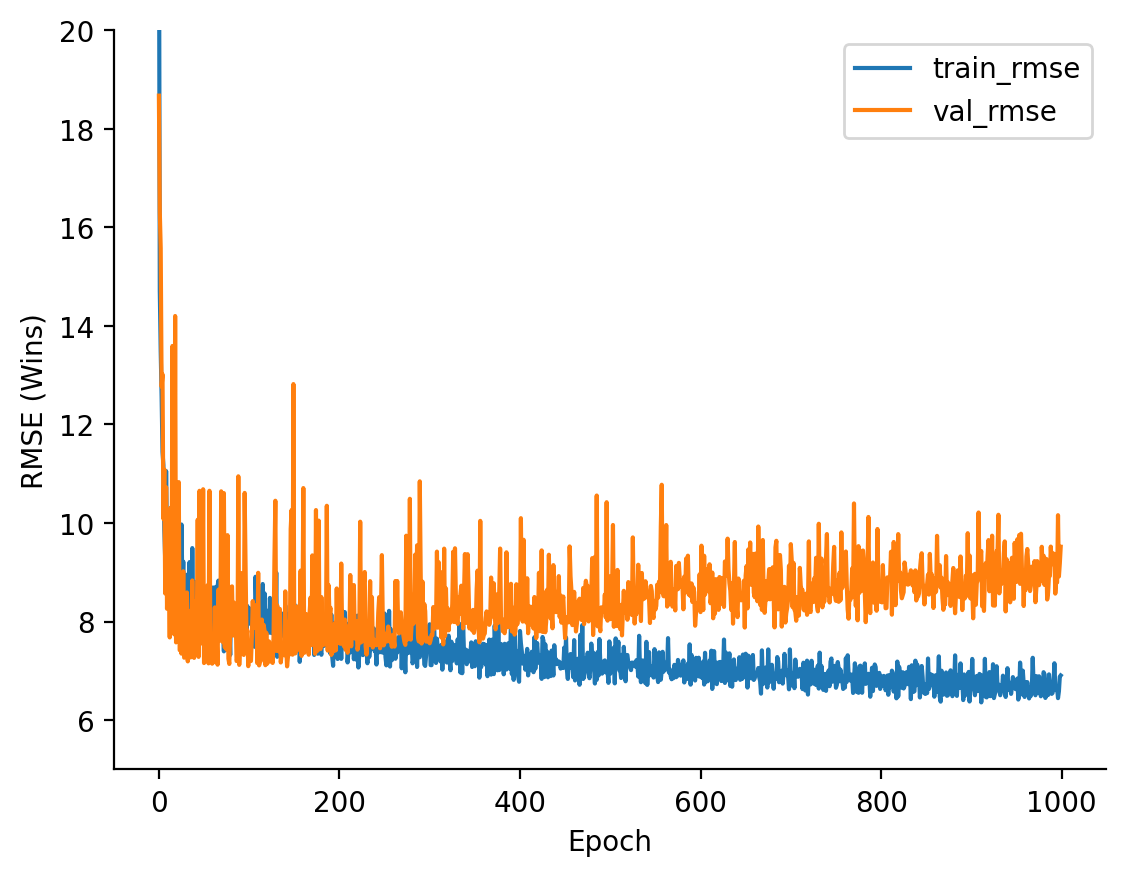

In [36]:
sns.lineplot(x=hist['epoch'], y=hist['mse'] ** .5,
                 label='train_rmse')
sns.lineplot(x=hist['epoch'], y=hist['val_mse'] ** .5,
                 label='val_rmse')
plt.ylabel('RMSE (Wins)')
plt.xlabel('Epoch')
plt.legend()
sns.despine()
plt.ylim([5,20])